# Plotting PyPSA results (simplified version 4-nodes clustering and 1 year data - Bolivia)

In [2]:
###### algunas cosas cambian si pongo como comentarios en el import de geoviews y hvplot (liberias conflictivas?)

import logging
import os

import pypsa
import yaml
import pandas as pd
import geopandas as gpd
#import geoviews as gv
#import hvplot.pandas 
import numpy as np
import scipy as sp
import networkx as nx

# plotting stuff
import matplotlib.pyplot as plt

plt.style.use("bmh")
import seaborn as sns  ###
import cartopy.crs as ccrs

sns.set(style="darkgrid")

from scipy.sparse import csgraph
from itertools import product

from shapely.geometry import Point, LineString
import shapely, shapely.prepared, shapely.wkt

logger = logging.getLogger(__name__)

pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", 70)

import sys

sys.path.append("../")  # to import helpers
from scripts._helpers import sets_path_to_root

sets_path_to_root("pypsa-earth")

max_node_size = 1.0  # maximum size of a node for plotting purposes [used in plots]

This is the repository path:  c:\Users\Lenovo\Desktop\pypsa-earth
Had to go 1 folder(s) up.


In [3]:
# utility function for nice plotting


def normalize_node_size(values, max_node_size=max_node_size):
    return values / values.max() * max_node_size

# Load all networks

In [4]:
# add_electricity_network = os.getcwd() + '/networks/elec.nc'
# n_add_el = pypsa.Network(add_electricity_network)

# clustered_network = os.getcwd() + '/networks/elec_s_20.nc'
# n_cluster = pypsa.Network(clustered_network)



#Se carga el documento (o la direccion/path del mismo) a una variable (solved_network)

solved_network = os.getcwd() + "/results/networks/elec_s_4_ec_lcopt_Co2L-6H.nc"

#Se cargan los resultados de la optimizacion del problema segun las caracteristicas definidas para el modelo en n_solve con la funcion (operador?) Network de pypsa

n_solve = pypsa.Network(solved_network)

INFO:pypsa.io:Imported network elec_s_4_ec_lcopt_Co2L-6H.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


# Solved network

In [5]:
n = n_solve

In [6]:
# ".global_constraints" muestra las restricciones consideradas para el modelo (en el config.yaml solo se tomo en cuenta el limite de emisiones) tonCO2/year

n.global_constraints

,sense,constant,mu,type,investment_period,carrier_attribute
GlobalConstraint,,,,,,
CO2Limit,<=,77500000.0,4.167427e-09,primary_energy,NaN,co2_emissions


In [7]:
#Calculo del precio promedio de energia promedio en la red (costo total de operacion)= ".objective" /  (sumatoria de las cargas variables en el tiempo)
# EURO/MWh

##### check why the value does not appear 
#   - It seems that while the model run before, due to restrictions on simulation, proper solving wasn't possible (by increasing tolerances of the solver the model gets actual results)


n.objective

419344647.7063408

### Spatial temporal resolution

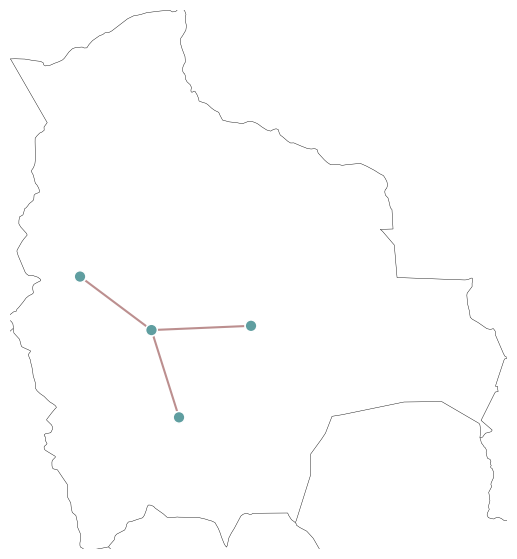

In [8]:
#Resultado grafico de la red electrica ideal (lineas verdes representan expansiones de la red)

#####beacuase all buses are not connected it might be that the problem is not fully solved 
# - Lines used in the model don't consider newer power lines (data bases were not apdated)
# - This is proved by comparing raw lines (all available lines in OSM) and clean lines (processed lines to be used in the model)
# - A linker is required to include new/additional data into the "all_clean_lines.geojson"

world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
shapes=world[world.name.isin(["Bolivia"])].set_index("name")

fig, ax = plt.subplots(figsize=(7, 7),subplot_kw={'projection': ccrs.PlateCarree()})

n.plot(ax=ax)
ax.set_extent([shapes.total_bounds[0], shapes.total_bounds[2],shapes.total_bounds[1], shapes.total_bounds[3]], crs=ccrs.PlateCarree())


In [9]:
#Se muestra el tamaño de la resolucion temporal del modelo - timesteps 
# - Currently the system is working with a toy version of Bolivia to allow faster solving times (6h time aggregation and a little over 5 months acoording the rules in the config.yaml file) 
# - A more complete model should be run eventually with different conditions (higher time resolution) or methods like tsam (https://tsam.readthedocs.io/en/latest/mathematicalBackgroundDoc.html)
#  

len(n.snapshots)

1460

### Overview components

In [10]:
#Imprimir la lista de componentes considerados en el dataframe creado

for c in n.iterate_components(list(n.components.keys())[2:]):
    print("Component '{}' has {} entries".format(c.name, len(c.df)))

Component 'Bus' has 12 entries
Component 'Carrier' has 16 entries
Component 'GlobalConstraint' has 1 entries
Component 'Line' has 3 entries
Component 'LineType' has 34 entries
Component 'TransformerType' has 14 entries
Component 'Link' has 16 entries
Component 'Load' has 4 entries
Component 'Generator' has 19 entries
Component 'StorageUnit' has 2 entries
Component 'Store' has 8 entries


### Energy balance

In [11]:
# ".stores_t" hace referencia a la energia que se puede almacenar en un bus (se usa para definir otras tecnologias como storage)
# - https://pypsa.readthedocs.io/en/latest/components.html#store

n.stores_t.p.sum()

Store
BO 0 H2        -8.470329e-22
BO 1 H2        -1.270549e-21
BO 2 H2        -8.470329e-22
BO 3 H2         2.117582e-21
BO 0 battery   -5.293956e-23
BO 1 battery    5.558654e-22
BO 2 battery    7.940934e-23
BO 3 battery   -1.058791e-22
dtype: float64

In [12]:
# se imprimen todos los generadores considerados en el modelo

##### check if loadshedding is being used in the config.yaml file, at the solving section 
# - load shedding is represented in the model by the inclution on additional "load" generation/generators 


n.generators

print(type(n.generators))
print(n.generators.columns)
n.generators

<class 'pandas.core.frame.DataFrame'>
Index(['p_nom_max', 'weight', 'p_nom', 'capital_cost', 'efficiency',
       'p_nom_min', 'marginal_cost', 'p_nom_extendable', 'carrier', 'bus',
       'control', 'p_nom_opt', 'sign', 'build_year', 'min_up_time',
       'min_down_time', 'up_time_before', 'down_time_before', 'type',
       'p_min_pu', 'p_max_pu', 'p_set', 'q_set', 'lifetime', 'committable',
       'start_up_cost', 'shut_down_cost', 'ramp_limit_up', 'ramp_limit_down',
       'ramp_limit_start_up', 'ramp_limit_shut_down'],
      dtype='object')


,p_nom_max,weight,p_nom,capital_cost,efficiency,p_nom_min,marginal_cost,p_nom_extendable,carrier,bus,control,p_nom_opt,sign,build_year,min_up_time,min_down_time,up_time_before,down_time_before,type,p_min_pu,p_max_pu,p_set,q_set,lifetime,committable,start_up_cost,shut_down_cost,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down
Generator,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
BO 0 OCGT,inf,0.000000,5.715140e+02,47234.561404,0.390,571.513987,58.395343,True,OCGT,BO 0,Slack,5.715140e+02,1.000,0,0,0,1,0,,0.0,1.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0
BO 0 onwind,6.239541e+05,61211.409931,7.135418e+00,109295.569252,1.000,7.135418,0.024899,False,onwind,BO 0,,7.135418e+00,1.000,0,0,0,1,0,,0.0,1.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0
BO 0 solar,2.404776e+05,33550.449062,1.497698e+01,50855.958267,1.000,14.976985,0.019234,False,solar,BO 0,,1.497698e+01,1.000,0,0,0,1,0,,0.0,1.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0
BO 1 OCGT,inf,0.000000,7.224879e+01,47234.561404,0.390,72.248791,58.394037,True,OCGT,BO 1,,2.573082e+02,1.000,0,0,0,1,0,,0.0,1.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0
BO 1 onwind,8.784195e+05,30119.280538,9.305016e+00,109295.569252,1.000,9.305016,0.024103,False,onwind,BO 1,,9.305016e+00,1.000,0,0,0,1,0,,0.0,1.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0
BO 1 ror,inf,260.721486,2.607215e+02,270940.715283,0.900,0.000000,0.010855,False,ror,BO 1,,2.607215e+02,1.000,0,0,0,1,0,,0.0,1.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0
BO 1 solar,5.530092e+05,82741.376980,3.460061e+01,50855.958267,1.000,34.600613,0.020161,False,solar,BO 1,,3.460061e+01,1.000,0,0,0,1,0,,0.0,1.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0
BO 2 OCGT,inf,0.000000,1.207441e+02,47234.561404,0.390,120.744063,58.394564,True,OCGT,BO 2,,1.207441e+02,1.000,0,0,0,1,0,,0.0,1.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0
BO 2 oil,inf,0.000000,3.399651e+01,38234.561404,0.393,33.996513,130.236515,False,oil,BO 2,,3.399651e+01,1.000,0,0,0,1,0,,0.0,1.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0


In [13]:
#Imprimir solo los generadores de Bolivia

########(this is only necessary if several countries are studied at the same time

idx = ['BO' in x for x in n.generators.index]
n.generators.loc[idx,:]

,p_nom_max,weight,p_nom,capital_cost,efficiency,p_nom_min,marginal_cost,p_nom_extendable,carrier,bus,control,p_nom_opt,sign,build_year,min_up_time,min_down_time,up_time_before,down_time_before,type,p_min_pu,p_max_pu,p_set,q_set,lifetime,committable,start_up_cost,shut_down_cost,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down
Generator,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
BO 0 OCGT,inf,0.000000,5.715140e+02,47234.561404,0.390,571.513987,58.395343,True,OCGT,BO 0,Slack,5.715140e+02,1.000,0,0,0,1,0,,0.0,1.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0
BO 0 onwind,6.239541e+05,61211.409931,7.135418e+00,109295.569252,1.000,7.135418,0.024899,False,onwind,BO 0,,7.135418e+00,1.000,0,0,0,1,0,,0.0,1.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0
BO 0 solar,2.404776e+05,33550.449062,1.497698e+01,50855.958267,1.000,14.976985,0.019234,False,solar,BO 0,,1.497698e+01,1.000,0,0,0,1,0,,0.0,1.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0
BO 1 OCGT,inf,0.000000,7.224879e+01,47234.561404,0.390,72.248791,58.394037,True,OCGT,BO 1,,2.573082e+02,1.000,0,0,0,1,0,,0.0,1.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0
BO 1 onwind,8.784195e+05,30119.280538,9.305016e+00,109295.569252,1.000,9.305016,0.024103,False,onwind,BO 1,,9.305016e+00,1.000,0,0,0,1,0,,0.0,1.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0
BO 1 ror,inf,260.721486,2.607215e+02,270940.715283,0.900,0.000000,0.010855,False,ror,BO 1,,2.607215e+02,1.000,0,0,0,1,0,,0.0,1.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0
BO 1 solar,5.530092e+05,82741.376980,3.460061e+01,50855.958267,1.000,34.600613,0.020161,False,solar,BO 1,,3.460061e+01,1.000,0,0,0,1,0,,0.0,1.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0
BO 2 OCGT,inf,0.000000,1.207441e+02,47234.561404,0.390,120.744063,58.394564,True,OCGT,BO 2,,1.207441e+02,1.000,0,0,0,1,0,,0.0,1.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0
BO 2 oil,inf,0.000000,3.399651e+01,38234.561404,0.393,33.996513,130.236515,False,oil,BO 2,,3.399651e+01,1.000,0,0,0,1,0,,0.0,1.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0


In [14]:
#Imprimir la suma de potencias nominales (2013) de los generadores de Bolivia

####### Data was not yet updated and therefore a big difference between real capacities in 2020 (largely oversized) and optimized installed capacities (relatively low changes)
# - To change this, additional plants have to be added to better represent the system

idx = ['BO' in x for x in n.generators.index]
n.generators.loc[idx,:].p_nom.sum()
# n.generators.loc[idx,:].p_nom_opt.sum()

4000001437.100461

In [15]:
# Difference between total load and generation
# losses = n.stores_t

n.generators_t.p.sum().sum() - n.loads_t.p.sum().sum()  # - substract storage losses


7294.890675256029

### Total installed generator capacity

In [33]:
gen_cap = n.generators.groupby(["carrier"]).sum()
gen_cap.to_csv('capacities_by_carrier.csv',index=False)
gen_cap


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_33800\3296247162.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  gen_cap = n.generators.groupby(["carrier"]).sum()


,p_nom_max,weight,p_nom,capital_cost,efficiency,p_nom_min,marginal_cost,p_nom_extendable,p_nom_opt,sign,build_year,min_up_time,min_down_time,up_time_before,down_time_before,p_min_pu,p_max_pu,p_set,q_set,lifetime,committable,start_up_cost,shut_down_cost,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down
carrier,,,,,,,,,,,,,,,,,,,,,,,,,,,
OCGT,NaN,0.000000,9.143409e+02,188938.245618,1.560,914.340881,233.579078,4,1.099400e+03,4.000,0,0,0,4,0,0.0,4.0,0.0,0.0,NaN,0,0.0,0.0,0.0,0.0,4.0,4.0
load,NaN,0.000000,4.000000e+09,0.000000,4.000,0.000000,4.039702,0,4.000000e+09,0.004,0,0,0,4,0,0.0,4.0,0.0,0.0,NaN,0,0.0,0.0,0.0,0.0,4.0,4.0
oil,inf,0.000000,3.399651e+01,38234.561404,0.393,33.996513,130.236515,0,3.399651e+01,1.000,0,0,0,1,0,0.0,1.0,0.0,0.0,inf,0,0.0,0.0,0.0,0.0,1.0,1.0
onwind,2.376047e+06,124486.370505,2.552861e+01,437182.277006,4.000,25.528608,0.098918,0,2.552861e+01,4.000,0,0,0,4,0,0.0,4.0,0.0,0.0,NaN,0,0.0,0.0,0.0,0.0,4.0,4.0
ror,NaN,344.006279,3.440063e+02,541881.430565,1.800,0.000000,0.020404,0,3.440063e+02,2.000,0,0,0,2,0,0.0,2.0,0.0,0.0,NaN,0,0.0,0.0,0.0,0.0,2.0,2.0
solar,1.869632e+06,324318.258522,1.192282e+02,203423.833068,4.000,119.228180,0.078782,0,1.192282e+02,4.000,0,0,0,4,0,0.0,4.0,0.0,0.0,NaN,0,0.0,0.0,0.0,0.0,4.0,4.0


In [17]:
n.stores_t.p.head()

Store,BO 0 H2,BO 1 H2,BO 2 H2,BO 3 H2,BO 0 battery,BO 1 battery,BO 2 battery,BO 3 battery
snapshot,,,,,,,,
2013-01-01 00:00:00,-4.703499e-08,-4.626317e-08,-4.712393e-08,-4.671992e-08,5.708422e-09,5.522133e-09,5.554300e-09,5.550192e-09
2013-01-01 06:00:00,-4.981634e-08,-4.896469e-08,-4.990826e-08,-4.945321e-08,4.027198e-09,3.828390e-09,3.842274e-09,3.832450e-09
2013-01-01 12:00:00,-5.090239e-08,-5.091291e-08,-5.024569e-08,-5.074097e-08,-8.616526e-09,-8.112691e-09,-8.032694e-09,-8.176379e-09
2013-01-01 18:00:00,-5.435976e-08,-5.387069e-08,-5.442987e-08,-5.403034e-08,1.599064e-09,1.177374e-09,9.824380e-10,1.268073e-09
2013-01-02 00:00:00,-5.747167e-08,-5.683528e-08,-5.766670e-08,-5.727131e-08,2.710311e-09,2.634433e-09,2.758661e-09,2.630605e-09


<AxesSubplot:xlabel='snapshot'>

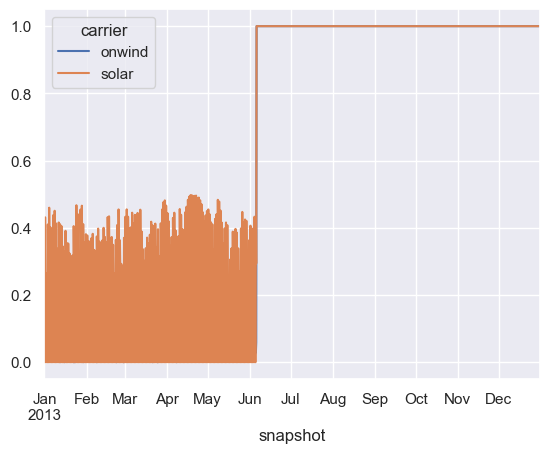

In [18]:
n.generators_t.p_max_pu.groupby(n.generators.carrier, axis=1).mean().plot()

In [19]:
# If 0, all renewable capacity potential is used
n.generators.p_nom_max.sum() - n.generators.p_nom_opt.sum()

inf

In [20]:
n.loads_t.p.sum().sum()

1889681.760407288

In [21]:
n.generators_t.p.sum().sum()

1896976.6510825441

In [22]:
#### pq la multiplicacion?

n.generators.iloc[:, :].groupby(["bus", "carrier"]).p_nom.sum() * 0.0000003

bus   carrier
BO 0  OCGT       1.714542e-04
      load       3.000000e+02
      onwind     2.140626e-06
      solar      4.493095e-06
BO 1  OCGT       2.167464e-05
      load       3.000000e+02
      onwind     2.791505e-06
      ror        7.821645e-05
      solar      1.038018e-05
BO 2  OCGT       3.622322e-05
      load       3.000000e+02
      oil        1.019895e-05
      onwind     1.986438e-06
      solar      1.378999e-05
BO 3  OCGT       4.495021e-05
      load       3.000000e+02
      onwind     7.400138e-07
      ror        2.498544e-05
      solar      7.105187e-06
Name: p_nom, dtype: float64

AssertionError: Colors not defined for all elements in the second MultiIndex level of bus_sizes, please make sure that all the elements are included in bus_colors or in n.carriers.color

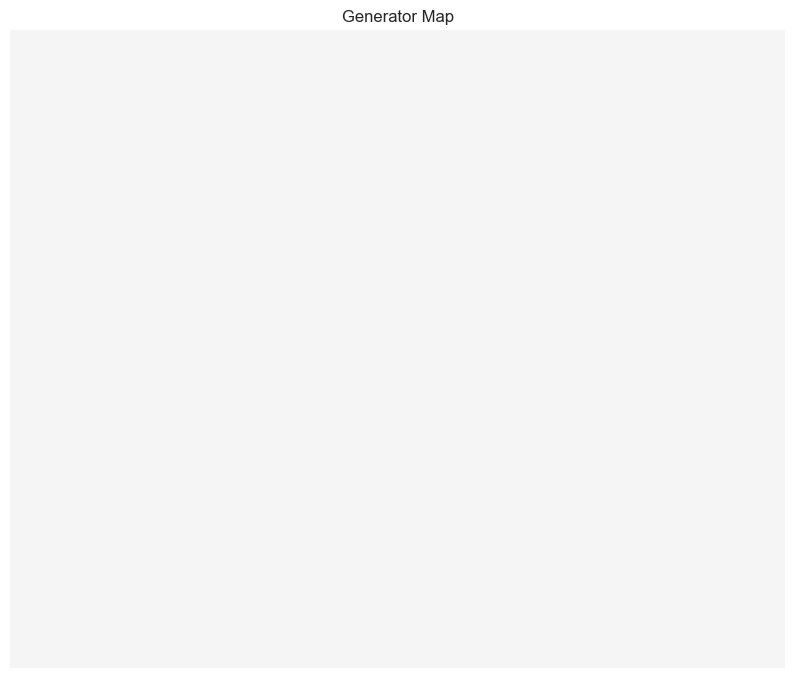

In [23]:
fig, ax = plt.subplots(
    figsize=(10, 10),
    subplot_kw={
        "projection": ccrs.PlateCarree()
    },  # PlateCarree(default), Mercator, Orthographic
)

# loading = (n3.lines_t.p0.abs().mean().sort_index() / (n3.lines.s_nom_opt*n.lines.s_max_pu).sort_index()).fillna(0.)

n.plot(
    margin=0.1,
    ax=None,
    geomap=True,  #'10m' leads to a beautiful high resolution map
    projection=None,
    bus_colors="cadetblue",
    bus_alpha=1,
    bus_sizes=normalize_node_size(
        n.generators.iloc[:, :].groupby(["bus", "carrier"]).p_nom_opt.sum()),
    bus_cmap=None,
    line_colors="rosybrown",
    link_colors="darkseagreen",  # loading
    transformer_colors="orange",
    line_widths=n.lines.s_nom_opt / 3e2,
    link_widths=1.5,
    transformer_widths=1.5,
    line_cmap=None,
    link_cmap=None,  # plt.cm.virdis (colordmap for line loading)
    transformer_cmap=None,
    flow=None,
    branch_components=None,
    layouter=None,
    title="Generator Map",
    boundaries=None,
    geometry=False,
    jitter=None,
    color_geomap=True,
)  # None or True

ax.axis("off");

### Demand

In [24]:
print(type(n.generators.iloc[:, :].groupby(["bus"]).p_nom_opt.sum()))

print(n.generators.iloc[:, :].groupby(["bus"]).p_nom_opt.sum())

<class 'pandas.core.series.Series'>
bus
BO 0    1.000001e+09
BO 1    1.000001e+09
BO 2    1.000000e+09
BO 3    1.000000e+09
Name: p_nom_opt, dtype: float64


<AxesSubplot:xlabel='snapshot'>

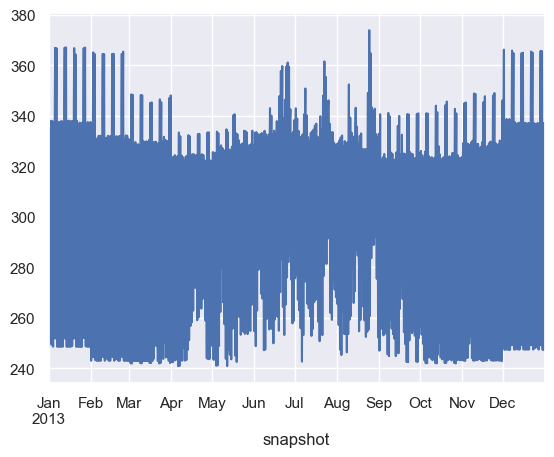

In [25]:
n.loads_t.p_set.loc["2013-01-01":"2014-01-01","BO 0"].plot()

Load
BO 0    440624.835541
BO 1    585502.562603
BO 2    472767.968399
BO 3    390786.393864
dtype: float64


<AxesSubplot:xlabel='Load'>

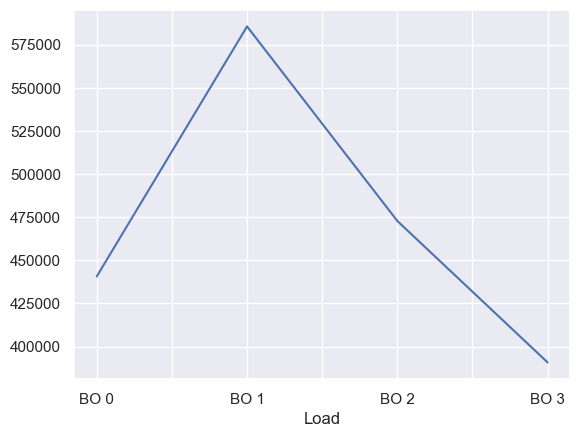

In [34]:
print(n.loads_t.p_set.sum())

n.loads_t.p_set.sum().plot()

In [27]:
a = n.loads_t.p_set.sum().rename("load").rename_axis("bus")
a.rename("load", inplace=True)
a.rename_axis("bus", inplace=True)
a

bus
BO 0    440624.835541
BO 1    585502.562603
BO 2    472767.968399
BO 3    390786.393864
Name: load, dtype: float64

In [ ]:
n.generators.iloc[:, :].groupby(["bus"]).p_nom_opt.sum()

###### potencia maxima?
#n.generators.iloc[:, :].groupby(["bus"]).p_max_pu.sum()

bus
BO 0    1.000000e+09
BO 1    1.000000e+09
BO 2    1.000000e+09
BO 3    1.000000e+09
BO 4    1.000003e+09
BO 5    1.000000e+09
BO 6    1.000002e+09
BO 7    1.000000e+09
BO 8    1.000000e+09
BO 9    1.000000e+09
Name: p_nom_opt, dtype: float64

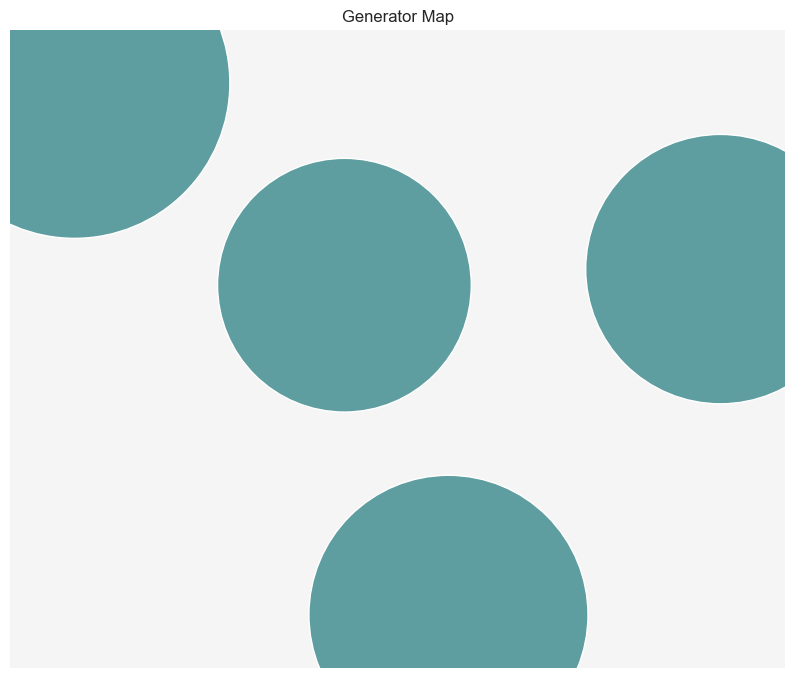

In [28]:
fig, ax = plt.subplots(
    figsize=(10, 10),
    subplot_kw={
        "projection": ccrs.PlateCarree()
    },  # PlateCarree(default), Mercator, Orthographic
)

# loading = (n3.lines_t.p0.abs().mean().sort_index() / (n3.lines.s_nom_opt*n.lines.s_max_pu).sort_index()).fillna(0.)

n.plot(
    margin=0.1,
    ax=None,
    geomap=True,  #'10m' leads to a beautiful high resolution map
    projection=None,
    bus_colors="cadetblue",
    bus_alpha=1,
    bus_sizes=normalize_node_size(
        n.loads_t.p_set.sum().rename("load").rename_axis("bus")
    ),  # n.loads_t.p_set.sum().rename("load").rename_axis("bus")*.0000003,
    bus_cmap=None,
    line_colors="rosybrown",
    link_colors="darkseagreen",  # loading
    transformer_colors="orange",
    line_widths=n.lines.s_nom_opt / 3000000000e2,
    link_widths=1.5,
    transformer_widths=1.5,
    line_cmap=None,
    link_cmap=None,  # plt.cm.virdis (colordmap for line loading)
    transformer_cmap=None,
    flow=None,
    branch_components=None,
    layouter=None,
    title="Generator Map",
    boundaries=None,
    geometry=False,
    jitter=None,
    color_geomap=True,
)  # None or True

ax.axis("off");

In [29]:
# backup
gen_serie = n.generators.iloc[:, :].groupby(["bus", "carrier"]).p_nom_opt.sum()
load_serie = n.loads_t.p_set.sum().rename("load").rename_axis("bus")

load_serie = pd.Series(
    load_serie.values,
    index=pd.MultiIndex.from_tuples([(id, "AC load") for id in load_serie.index]),
)

tot_serie = pd.concat([gen_serie, load_serie])  # .groupby(['bus', 'carrier']).sum()

pd.concat([gen_serie, load_serie])

bus   carrier
BO 0  OCGT       5.715140e+02
      load       1.000000e+09
      onwind     7.135418e+00
      solar      1.497698e+01
BO 1  OCGT       2.573082e+02
      load       1.000000e+09
      onwind     9.305016e+00
      ror        2.607215e+02
      solar      3.460061e+01
BO 2  OCGT       1.207441e+02
      load       1.000000e+09
      oil        3.399651e+01
      onwind     6.621461e+00
      solar      4.596663e+01
BO 3  OCGT       1.498340e+02
      load       1.000000e+09
      onwind     2.466713e+00
      ror        8.328479e+01
      solar      2.368396e+01
BO 0  AC load    4.406248e+05
BO 1  AC load    5.855026e+05
BO 2  AC load    4.727680e+05
BO 3  AC load    3.907864e+05
dtype: float64

### Plot of Average Marginal Price

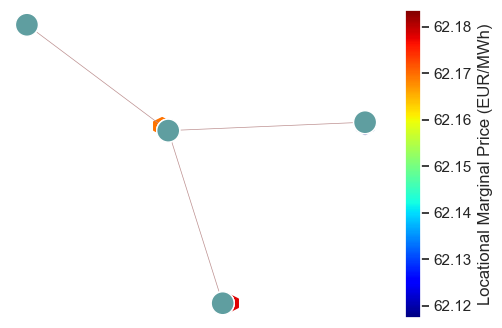

In [30]:
now = n.snapshots[4]  ##one specific time

fig, ax = plt.subplots(1, 1, subplot_kw={"projection": ccrs.PlateCarree()})
fig.set_size_inches(6, 4)

n.plot(ax=ax, line_widths=pd.Series(0.5, n.lines.index))
plt.hexbin(
    n.buses.x,
    n.buses.y,
    gridsize=20,
    # C=n.buses_t.marginal_price.loc[now], #at one time (previous set up by scigrid)
    C=n.buses_t.marginal_price.sum()
    / len(n.snapshots[:]),  # Marginal price averaged over the whole year (My version)
    # - shows in which regions electricity will be cheap and where el. intensive companies should be placed.
    cmap=plt.cm.jet,
)

# for some reason the colorbar only works with graphs plt.plot
# and must be attached plt.colorbar

cb = plt.colorbar()
cb.set_label("Locational Marginal Price (EUR/MWh)")

### Storage

<AxesSubplot:xlabel='snapshot'>

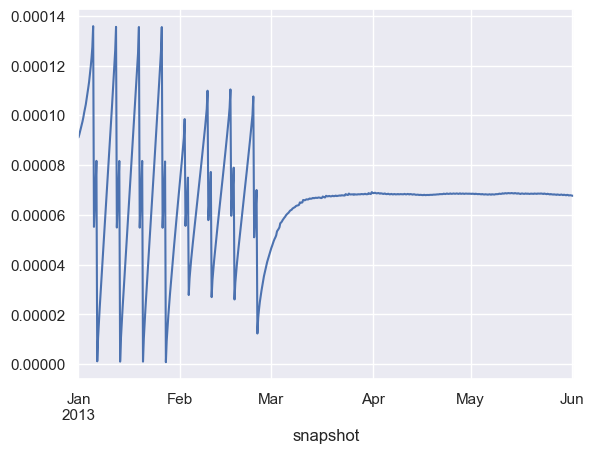

In [31]:
n.stores_t.e.loc["2013-01-01":"2013-06-01"].sum(axis=1).plot()

In [32]:
n.links.iloc[:].groupby(["carrier"]).p_nom_opt.sum()

carrier
H2 electrolysis       0.000001
H2 fuel cell          0.000012
battery charger       0.000003
battery discharger    0.000003
Name: p_nom_opt, dtype: float64